In [196]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [228]:
import pandas as pd

def extract_course_columns(df):
    course_columns = [col for col in df.columns if col.startswith('Course')]
    first_try_columns = [col for col in course_columns if col.endswith('-1')]
    resit_columns = [col for col in course_columns if col.endswith('-R')]
    final_grade_columns = [col for col in course_columns if not (col.endswith('-1') or col.endswith('-R'))]

    return first_try_columns, resit_columns, final_grade_columns

file_path = '/content/BSA-dataset-synthetic.xlsx'
sheet_name = 0  # Specify the sheet name here

df = pd.read_excel(file_path, sheet_name=sheet_name)

# Extract course columns
first_try_columns, resit_columns, final_grade_columns = extract_course_columns(df)

print("First Try Columns:", first_try_columns)
print("Resit Columns:", resit_columns)
print("Final Grade Columns:", final_grade_columns)



First Try Columns: ['Course3-1', 'Course9-1', 'Course8-1', 'Course7-1']
Resit Columns: ['Course3-R', 'Course9-R']
Final Grade Columns: ['Course23', 'Course26', 'Course3', 'Course16', 'Course8', 'Course9', 'Course22', 'Course7', 'Course25', 'Course24']


In [198]:
# Create resits_needed column and initialize with zeros
df['resits_needed'] = 0

# Loop through each column in first_try_columns
for col in first_try_columns:
    # Increment resits_needed by 1 if the column value is less than 5.5 or missing
    df.loc[(df[col] < 5.5) | (df[col].isna()), 'resits_needed'] += 1



In [199]:
# Initialize an empty list to store column names
block1and2_results = []

# Iterate through each column in first_try_columns
for col in first_try_columns:
    # Extract the course number X from the column name
    course_num = col.split('-')[0]

    # Add the initial attempt column (CourseX-1)
    block1and2_results.append(col)

    # Check if there's a corresponding resit column (CourseX-R)
    resit_col = f"{course_num}-R"
    if resit_col in resit_columns:
        # Add the resit column to the list
        block1and2_results.append(resit_col)

# Print the resulting list of column names
print("block1and2_results:", block1and2_results)

block1and2_results: ['Course3-1', 'Course3-R', 'Course9-1', 'Course9-R', 'Course8-1', 'Course7-1']


In [200]:
# Initialize the 'absent' column with zeros
df['absent'] = 0

# Iterate through each column in block1and2_results
for col in block1and2_results:
    # Extract the course number X from the column name
    course_num = col.split('-')[0]

    # Check if it's an initial attempt column
    if col.endswith('-1'):
        # Increment 'absent' by 1 if the initial attempt column is missing
        df.loc[df[col].isna(), 'absent'] += 1
    elif col.endswith('-R'):
        # Check if there's a corresponding initial attempt column and increment 'absent' accordingly
        initial_col = f"{course_num}-1"
        df.loc[(df[col].isna()) & ((df[initial_col] < 5.5) | df[initial_col].isna()), 'absent'] += 1



In [201]:
# Select columns of interest (block1and2_results and 'absent') and display their values
print(df.loc[:, block1and2_results + ['absent']])


    Course3-1  Course3-R  Course9-1  Course9-R  Course8-1  Course7-1  absent
0         1.5        2.5        NaN        NaN        NaN        NaN       4
1         3.5        3.5        5.0        NaN        2.0        NaN       2
2         2.5        2.5        1.0        NaN        2.0        NaN       2
3         5.0        5.0        1.0        NaN        3.0        NaN       2
4         NaN        NaN        NaN        NaN        NaN        NaN       6
..        ...        ...        ...        ...        ...        ...     ...
56        7.5        NaN        6.5        NaN        6.5        6.0       0
57        6.0        NaN        2.0        NaN        5.5        5.0       1
58        6.0        NaN        1.0        1.0        5.5        6.5       0
59        7.0        NaN        5.0        7.5        6.5        4.5       0
60        7.0        NaN        8.0        NaN        6.0        8.0       0

[61 rows x 7 columns]


In [202]:
# Calculate average_gradeB1B2 as the row mean of specified columns
columns_for_average = block1and2_results.copy()  # Make a copy of block1and2_results
df['average_gradeB1B2'] = df[columns_for_average].mean(axis=1)  # Calculate mean across columns
df['average_gradeB1B2'] = df['average_gradeB1B2'].round(2)  # Round to two decimal places


In [203]:
# Initialize dictionaries to store mean values for each course
mean_courses = {}

# Calculate mean for each course in block1and2_results
for col in block1and2_results:
    # Extract the course number X from the column name
    course_num = col.split('-')[0]

    # Calculate mean for each course and store it in the dictionary
    if course_num not in mean_courses:
        mean_courses[course_num] = df[col].mean()

# Print mean values for each course
for course, mean in mean_courses.items():
    print(f"Mean for Course {course}: {mean}")


Mean for Course Course3: 6.155172413793103
Mean for Course Course9: 5.954545454545454
Mean for Course Course8: 5.017857142857143
Mean for Course Course7: 5.695652173913044


In [204]:
# Initialize dictionaries to store sum and count of grades for each course
sum_initial_grades = {}
count_initial_grades = {}
sum_resit_grades = {}
count_resit_grades = {}

# Calculate sum and count of grades for each course in block1and2_results
for col in block1and2_results:
    # Extract the course number X from the column name
    course_num = col.split('-')[0]

    # Check if it's an initial attempt column
    if col.endswith('-1'):
        # Add the grade to the sum of grades for the course
        sum_initial_grades[course_num] = sum_initial_grades.get(course_num, 0) + df[col].sum()
        # Increment the count of grades for the course
        count_initial_grades[course_num] = count_initial_grades.get(course_num, 0) + df[col].count()
    elif col.endswith('-R'):
        # Add the grade to the sum of grades for the course
        sum_resit_grades[course_num] = sum_resit_grades.get(course_num, 0) + df[col].sum()
        # Increment the count of grades for the course
        count_resit_grades[course_num] = count_resit_grades.get(course_num, 0) + df[col].count()

# Calculate mean for each course and print the results
for course, sum_grade in sum_initial_grades.items():
    mean_initial_grade = sum_grade / count_initial_grades[course]
    print(f"Mean for Initial Attempt of Course {course}: {mean_initial_grade:.2f}")

for course, sum_grade in sum_resit_grades.items():
    mean_resit_grade = sum_grade / count_resit_grades[course]
    print(f"Mean for Resit of Course {course}: {mean_resit_grade:.2f}")



Mean for Initial Attempt of Course Course3: 6.16
Mean for Initial Attempt of Course Course9: 5.95
Mean for Initial Attempt of Course Course8: 5.02
Mean for Initial Attempt of Course Course7: 5.70
Mean for Resit of Course Course3: 5.21
Mean for Resit of Course Course9: 4.39


In [205]:
# Initialize a list to store mean grades for all attempts
all_means = []

# Calculate mean for each course for initial attempts and add to the list
for course, sum_grade in sum_initial_grades.items():
    mean_initial_grade = sum_grade / count_initial_grades[course]
    all_means.append(mean_initial_grade)

# Calculate mean for each course for resit attempts and add to the list
for course, sum_grade in sum_resit_grades.items():
    mean_resit_grade = sum_grade / count_resit_grades[course]
    all_means.append(mean_resit_grade)

# Print the list of mean grades for all attempts
print("Mean for All Attempts:", all_means)


Mean for All Attempts: [6.155172413793103, 5.954545454545454, 5.017857142857143, 5.695652173913044, 5.214285714285714, 4.388888888888889]


In [206]:
# Calculate mean_program1B1B2 as the row mean of mean_course values
mean_programB1B2 = sum(all_means) / len(all_means)
mean_programB1B2 = round(mean_programB1B2, 2)

# Update mean_course values with rounded values
for course, mean in mean_courses.items():
    df[f'mean_course{course}'] = round(mean, 2)

# Update mean_program1B1B2 with rounded value
df['mean_programB1B2'] = round(mean_programB1B2, 2)


In [207]:
# Calculate deviationB1B2 as the difference between average_gradeB1B2 and mean_program1B1B2
df['deviationB1B2'] = df['average_gradeB1B2'] - df['mean_programB1B2']
df['deviationB1B2'] = round(df['deviationB1B2'], 2)

In [208]:
# Create 'Dutch' column with True/False values based on the condition
df['Dutch'] = (df['Nationality'] == 'Nederland')


df['Dutch'] = df['Dutch'].astype(int)

# Create 'Dutch' column with True/False values based on the condition
df['Non-Dutch'] = (df['Nationality'] != 'Nederland')


df['Non-Dutch'] = df['Non-Dutch'].astype(int)

In [209]:
# Iterate through block1and2_results to create passed columns
for col in block1and2_results:
    # Extract the course number and attempt type from the column name
    course_num, attempt_type = col.split('-')

    # Check if it's an initial attempt column
    if attempt_type == '1':
        # Create the passed column if it doesn't exist
        if f'passed{course_num}' not in df.columns:
            df[f'passed{course_num}'] = 0

        # Set passed column to 1 if the grade is greater than or equal to 5.5
        df.loc[df[col] >= 5.5, f'passed{course_num}'] = 1

    # Check if it's a resit attempt column
    elif attempt_type == 'R':
        # Set passed column to 1 if the resit attempt is greater than or equal to 5.5
        df.loc[df[col] >= 5.5, f'passed{course_num}'] = 1

        # Set passed column to 1 if the resit attempt is missing and the initial attempt is greater than or equal to 5.5
        initial_col = next((c for c in block1and2_results if c.startswith(f'Course{course_num}-1')), None)
        if initial_col:
            df.loc[(df[col].isna()) & (df[initial_col] >= 5.5), f'passed{course_num}'] = 1



In [210]:
# Initialize the YEAR column with zeros
df['YEAR'] = 0

# Loop through each column specified in the varlist
for var in ['Course23', 'Course26', 'Course3', 'Course16', 'Course8', 'Course9', 'Course22', 'Course7', 'Course25', 'Course24']:
    df['YEAR'] += df[var].apply(lambda x: 6 if x >= 5.5 and not pd.isnull(x) else 0)

In [211]:
# Initialize the YEAR column with zeros
df['YEAR'] = 0

# Loop through each column specified in the final_grade_columns list
for var in final_grade_columns:
    df['YEAR'] += df[var].apply(lambda x: 6 if x >= 5.5 and not pd.isnull(x) else 0)


In [212]:
# Initialize the YEAR column with zeros
df['YEAR'] = 0

# Loop through each column specified in the final_grade_columns list
for var in final_grade_columns:
    df['YEAR'] += df[var].apply(lambda x: 6 if x >= 5.5 and not pd.isnull(x) else 0)


In [213]:
# Generate the passed42 column and convert boolean to integer
df['passed42'] = (df['YEAR'] >= 42).astype(int)
df['passed36'] = (df['YEAR'] >= 36).astype(int)
df['passed48'] = (df['YEAR'] >= 48).astype(int)


df = pd.get_dummies(df, columns=['Gender', 'PreEducation'], dtype=int)


non_categorical_columns = [col for col in df.columns if col not in ['Gender', 'Nationality', 'PreEducation', 'Program', 'Year', 'BSA']]
df[non_categorical_columns] = df[non_categorical_columns].fillna(0)

In [214]:
columns_to_drop = ['train', 'Credits-Y1', 'BSA','Program', 'YEAR','Year', 'mean_programB1B2', 'Nationality']



# Drop the specified columns
df.drop(columns=columns_to_drop, inplace=True)

In [215]:
# Drop the columns specified in final_grade_columns
df.drop(columns=final_grade_columns, inplace=True)


In [216]:
# Replace 'target_column' with the name of your target column
X = df.drop(columns=['passed36','passed42','passed48'])
y = df['passed42']


In [217]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [218]:
# Create a baseline Random Forest Classifier
baseline_rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the baseline model
baseline_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_baseline = baseline_rf_classifier.predict(X_test)

# Evaluate the baseline model
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
precision_baseline = precision_score(y_test, y_pred_baseline, average='binary')
recall_baseline = recall_score(y_test, y_pred_baseline, average='binary')
f1_baseline = f1_score(y_test, y_pred_baseline, average='binary')

# Print the baseline metrics
print('Baseline Model Performance:')
print(f'Accuracy: {accuracy_baseline}')
print(f'Precision: {precision_baseline}')
print(f'Recall: {recall_baseline}')
print(f'F1 Score: {f1_baseline}')
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_baseline))
print('Classification Report:')
print(classification_report(y_test, y_pred_baseline))

Baseline Model Performance:
Accuracy: 0.7368421052631579
Precision: 0.7777777777777778
Recall: 0.7
F1 Score: 0.7368421052631577
Confusion Matrix:
[[7 2]
 [3 7]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.78      0.74         9
           1       0.78      0.70      0.74        10

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



In [219]:
# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found by Grid Search
print(f'Best parameters found: {grid_search.best_params_}')


Fitting 3 folds for each of 324 candidates, totalling 972 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters found: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [220]:
# Create the model with the best parameters found by Grid Search
best_rf_classifier = RandomForestClassifier(
    max_depth=grid_search.best_params_['max_depth'],
    max_features=grid_search.best_params_['max_features'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    n_estimators=grid_search.best_params_['n_estimators'],
    random_state=42
)

# Train the model with the best parameters
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set with the best model
y_pred_best = best_rf_classifier.predict(X_test)

# Evaluate the model with the best parameters
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best, average='binary')
recall_best = recall_score(y_test, y_pred_best, average='binary')
f1_best = f1_score(y_test, y_pred_best, average='binary')

# Print the metrics for the best model
print('Best Model Performance:')
print(f'Accuracy: {accuracy_best}')
print(f'Precision: {precision_best}')
print(f'Recall: {recall_best}')
print(f'F1 Score: {f1_best}')
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_best))
print('Classification Report:')
print(classification_report(y_test, y_pred_best))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Model Performance:
Accuracy: 0.7368421052631579
Precision: 0.7777777777777778
Recall: 0.7
F1 Score: 0.7368421052631577
Confusion Matrix:
[[7 2]
 [3 7]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.78      0.74         9
           1       0.78      0.70      0.74        10

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



In [221]:
#overfitting?

#y_train_pred = best_rf_classifier.predict(X_train)

#acc = accuracy_score(y_train, y_train_pred)
#prec= precision_score(y_train, y_train_pred, average='binary')
#rec = recall_score(y_train, y_train_pred, average='binary')
#f1 = f1_score(y_train, y_train_pred, average='binary')

# Print the metrics for the best model

#print(f'Accuracy: {acc}')
#print(f'Precision: {prec}')
#print(f'Recall: {rec}')
#print(f'F1 Score: {f1}')


In [222]:
# Print the predictions made by the best model
print("Best Model Predictions:")
print(y_pred_best)


Best Model Predictions:
[0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1]


In [223]:
# Get the feature importances of the best model
feature_importances_best = best_rf_classifier.feature_importances_


feature_names = X.columns

# Create a DataFrame for better visualization
importance_df_best = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_best
})

# Sort the DataFrame by importance
importance_df_best = importance_df_best.sort_values(by='Importance', ascending=False)

# Display the DataFrame
print('Feature Importances of the Best Model:')
print(importance_df_best)


Feature Importances of the Best Model:
                     Feature  Importance
7              resits_needed    0.136916
6               Credits-B1B2    0.135795
9          average_gradeB1B2    0.132006
2                  Course8-1    0.116967
14             deviationB1B2    0.108587
3                  Course7-1    0.078988
20             passedCourse7    0.078557
1                  Course9-1    0.045353
0                  Course3-1    0.042641
8                     absent    0.038966
19             passedCourse8    0.029713
5                  Course9-R    0.009708
18             passedCourse9    0.008789
22                  Gender_M    0.007950
21                  Gender_F    0.007791
23  PreEducation_Buitenlands    0.005477
26          PreEducation_Vwo    0.004744
16                 Non-Dutch    0.004079
4                  Course3-R    0.003621
15                     Dutch    0.001854
17             passedCourse3    0.001135
25       PreEducation_Overig    0.000327
24          PreEdu

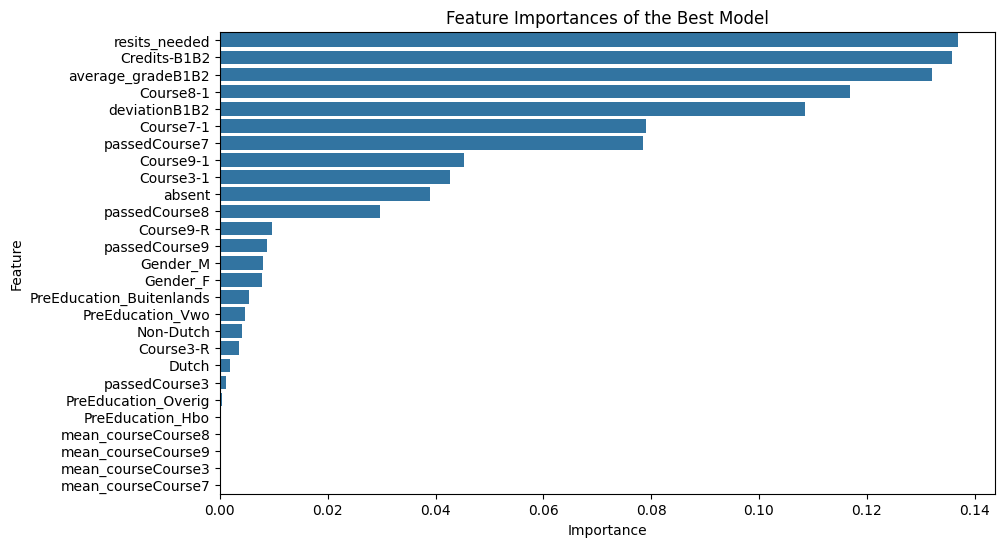

In [224]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_best)
plt.title('Feature Importances of the Best Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [225]:
correlation_matrix = X_train.corr()

print(correlation_matrix)

                          Course3-1  Course9-1  Course8-1  Course7-1  \
Course3-1                  1.000000   0.516434   0.689938   0.692854   
Course9-1                  0.516434   1.000000   0.629753   0.470995   
Course8-1                  0.689938   0.629753   1.000000   0.794136   
Course7-1                  0.692854   0.470995   0.794136   1.000000   
Course3-R                 -0.343474  -0.132878  -0.270230  -0.365133   
Course9-R                  0.035027  -0.210429  -0.000173  -0.019837   
Credits-B1B2               0.718303   0.691290   0.884155   0.883153   
resits_needed             -0.713620  -0.680321  -0.868357  -0.886633   
absent                    -0.670951  -0.635037  -0.620664  -0.585289   
average_gradeB1B2          0.865176   0.729539   0.858677   0.826158   
mean_courseCourse3              NaN        NaN        NaN        NaN   
mean_courseCourse9              NaN        NaN        NaN        NaN   
mean_courseCourse8              NaN        NaN        NaN       

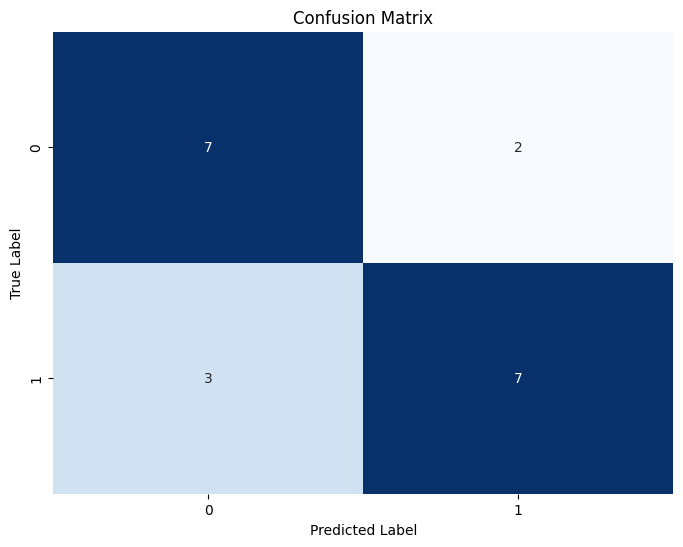

In [226]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
